# <center> CS677 - Fall2025 : Machine Learning
# <center> Final Project
## <center> Professor: Dr. Krishna Bathula
### <center> By: Ran Roffe, Kiara Jamal, Stanely Occean


In this notebook, we taclked the problem of predicting the median family income in New York City based on the census tracts dataset. The dataset is available on Kaggle and can be downloaded using the Kaggle API. We decided to take 2 approaches to this problem: regression and classification. We used regression because the target variable, `income` is continuous, while we used classification by seperating the target column into two categories: high-income and low-income based on the median.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import kagglehub
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

# Regression Approach

## 1. Problem Statement


In this project, our goal is to find out in what ways social and demographic changes affect median family income in the different census tracts of New York City. 

We pick a NYC Census publicly available dataset (`new-york-city-census-data`) for the analysis of the city to figure out the relationship of income with the characteristics of population, employment levels, poverty rates, and other neighborhood attributes.

Since the prediction is the median household income, this is a regression problem, as the target variable is continuous. 

## 2. Exploratory Data Analysis

In [57]:
path = kagglehub.dataset_download("muonneutrino/new-york-city-census-data")
print("Path to dataset files:", path)

df = pd.read_csv(os.path.join(path, 'nyc_census_tracts.csv'))
df.head()

Path to dataset files: C:\Users\ranro\.cache\kagglehub\datasets\muonneutrino\new-york-city-census-data\versions\2


,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusTract      2167 non-null   int64  
 1   County           2167 non-null   object 
 2   Borough          2167 non-null   object 
 3   TotalPop         2167 non-null   int64  
 4   Men              2167 non-null   int64  
 5   Women            2167 non-null   int64  
 6   Hispanic         2128 non-null   float64
 7   White            2128 non-null   float64
 8   Black            2128 non-null   float64
 9   Native           2128 non-null   float64
 10  Asian            2128 non-null   float64
 11  Citizen          2167 non-null   int64  
 12  Income           2101 non-null   float64
 13  IncomeErr        2101 non-null   float64
 14  IncomePerCap     2121 non-null   float64
 15  IncomePerCapErr  2121 non-null   float64
 16  Poverty          2125 non-null   float64
 17  ChildPoverty  

In [59]:
df.describe()

,CensusTract,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,2.167000e+03,2167.000000,2167.000000,2167.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2167.000000,...,2124.000000,2124.000000,2124.000000,2106.000000,2167.000000,2124.000000,2124.00000,2124.000000,2124.000000,2125.000000
mean,3.605476e+10,3888.667743,1852.812183,2035.855561,26.624671,33.055827,23.950799,0.198590,13.442622,2436.468389,...,9.048070,2.306921,3.749105,40.831576,1813.498385,79.536205,14.19355,6.151271,0.118644,9.757788
std,2.594875e+07,2240.050968,1063.921420,1212.765249,22.662106,30.421463,29.476758,0.700418,16.446275,1538.399585,...,9.623892,2.872501,4.560174,7.105916,1180.593180,6.923979,7.23155,3.851846,0.391563,5.786948
min,3.600500e+10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,15.200000,0.000000,38.600000,0.00000,0.000000,0.000000,0.000000
25%,3.604703e+10,2359.500000,1113.000000,1224.500000,9.000000,4.100000,1.500000,0.000000,2.100000,1446.000000,...,3.300000,0.500000,1.300000,37.200000,1052.500000,75.000000,8.80000,3.500000,0.000000,5.900000
50%,3.604712e+10,3550.000000,1699.000000,1848.000000,18.400000,22.950000,7.800000,0.000000,6.700000,2140.000000,...,6.500000,1.500000,2.800000,41.400000,1579.000000,79.900000,13.30000,5.600000,0.000000,8.800000
75%,3.608103e+10,4957.500000,2360.500000,2571.500000,39.900000,60.100000,39.075000,0.000000,18.925000,2976.000000,...,10.800000,3.200000,5.100000,45.375000,2273.500000,84.400000,18.70000,8.200000,0.000000,12.600000
max,3.608599e+10,28926.000000,13460.000000,15466.000000,100.000000,100.000000,100.000000,11.300000,89.800000,22905.000000,...,100.000000,55.600000,100.000000,70.500000,12780.000000,100.000000,53.70000,61.400000,3.900000,100.000000


We can already spot some interesting things:
- Columns like `TotalPop`, `Men`, `Women`, etc., have a wide spread.

- Some columns have a minimum of 0 which might indicate missing data. This could also mean that these are actual zero values. We can consider removing them if it makes sense according to the field of the data.

- `TotalPop`, `Men`, and `Women` exhibit minimal variation in quartiles, but the standard deviation for Men and Women is relatively high, implying some tracts have skewed gender distributions.

- Racial and ethnic composition (Hispanic, White, Black, Asian, Native) shows considerable variability.

- Poverty and ChildPoverty rates vary considerably across tracts, with the maximum values being more than double the median values - this suggests notable disparities in economic hardship.

- Occupation types (Professional, Service, Office, Construction, Production) vary widely. The distribution in these fields can reflect the economic base of different tracts.

In [60]:
# remove rows where TotalPop is 0, as they don't represent residential areas
df = df[df['TotalPop'] > 0].copy()

# remove income related columns and identifier
df = df.drop(columns=['IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'CensusTract'])
print(f"Shape of the dataframe after removing zero-population tracts: {df.shape}")
df.info()

Shape of the dataframe after removing zero-population tracts: (2128, 32)
<class 'pandas.core.frame.DataFrame'>
Index: 2128 entries, 0 to 2165
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   County        2128 non-null   object 
 1   Borough       2128 non-null   object 
 2   TotalPop      2128 non-null   int64  
 3   Men           2128 non-null   int64  
 4   Women         2128 non-null   int64  
 5   Hispanic      2128 non-null   float64
 6   White         2128 non-null   float64
 7   Black         2128 non-null   float64
 8   Native        2128 non-null   float64
 9   Asian         2128 non-null   float64
 10  Citizen       2128 non-null   int64  
 11  Income        2101 non-null   float64
 12  Poverty       2125 non-null   float64
 13  ChildPoverty  2107 non-null   float64
 14  Professional  2124 non-null   float64
 15  Service       2124 non-null   float64
 16  Office        2124 non-null   float64
 17  Con

#### Plot the Distribution of the Target Variable: `Income`

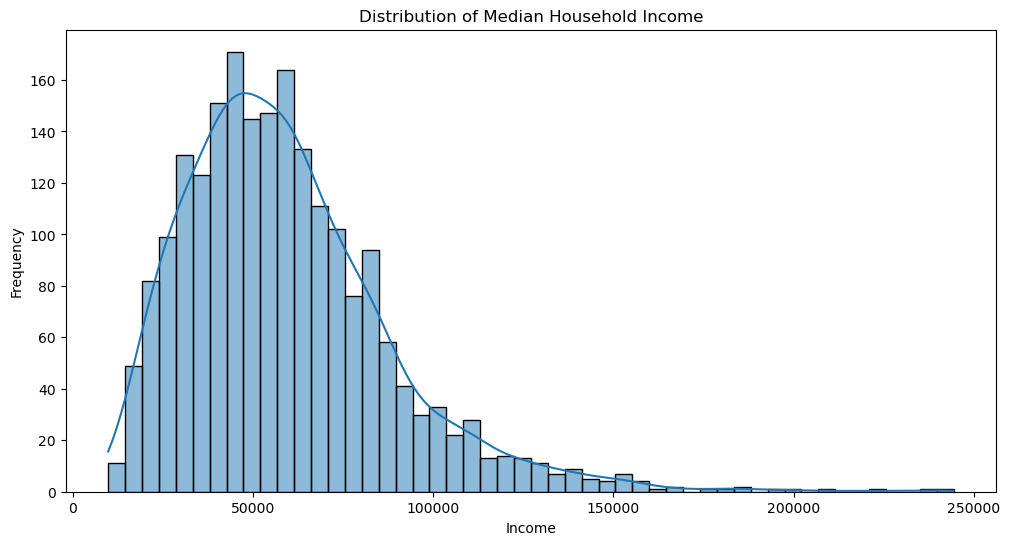

In [61]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Income'].dropna(), kde=True, bins=50)
plt.title('Distribution of Median Household Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

The income distribution is right-skewed, which is common for income data. We will apply a log transformation later during preprocessing to address this.

#### Plot for Distribution of Unemployment Rate

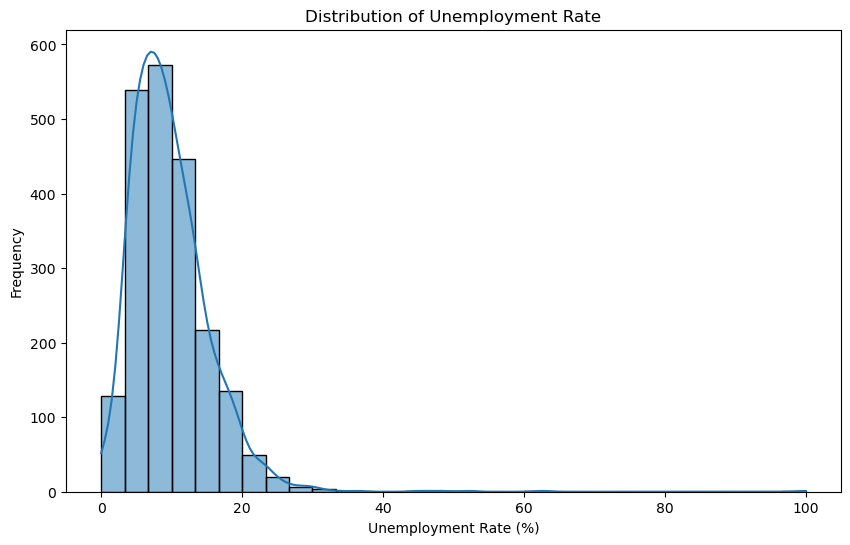

In [62]:
#distribution of unemployment rate
plt.figure(figsize=(10, 6))
sns.histplot(df['Unemployment'].dropna(), kde=True, bins=30)
plt.title('Distribution of Unemployment Rate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Frequency')
plt.show()

The​‍​‌‍​‍‌​‍​‌‍​‍‌ histogram for unemployment rate shows a right-skewed distribution. Many of the census tracts have low and moderate unemployment rates, thus they are to be seen on the left side of the plot. However, a lengthy tail reaching out on the right can be seen, which shows that a few tracts have very high unemployment rates. As a result, this statement confirms the existence of these few areas which, on the one hand, cause the total income level to fluctuate due to their high unemployment rates, and on the other hand, they influence the rest of the area by economic ​‍​‌‍​‍‌​‍​‌‍​‍‌challenges.

#### Plot Income vs. Poverty Rate

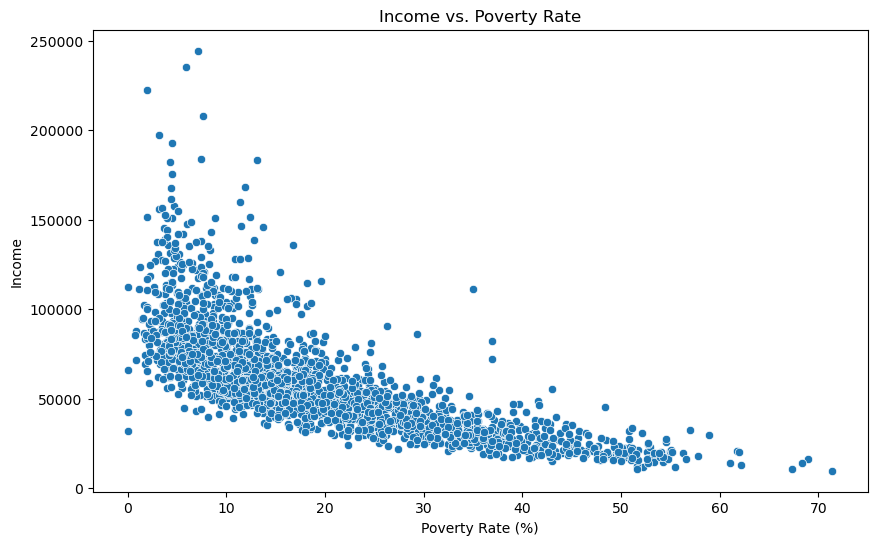

In [63]:
#income vs poverty rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Poverty', y='Income', data=df.dropna(subset=['Poverty', 'Income']))
plt.title('Income vs. Poverty Rate')
plt.xlabel('Poverty Rate (%)')
plt.ylabel('Income')
plt.show()

This​‍​‌‍​‍‌​‍​‌‍​‍‌ scatter plot illustrates an apparent inverse relationship between the poverty rate and the median household income. As the poverty rate moves up, the median income most of the time goes down considerably. This is a powerful evidence for the high negative correlation that has been referred to and it shows that poverty levels can be considered as one of the most influential factors of income in these census tracts. Few places with the low rate of poverty are the ones that are likely to have high incomes and the other way ​‍​‌‍​‍‌​‍​‌‍​‍‌around.

#### Plot Income vs. Professional occupations

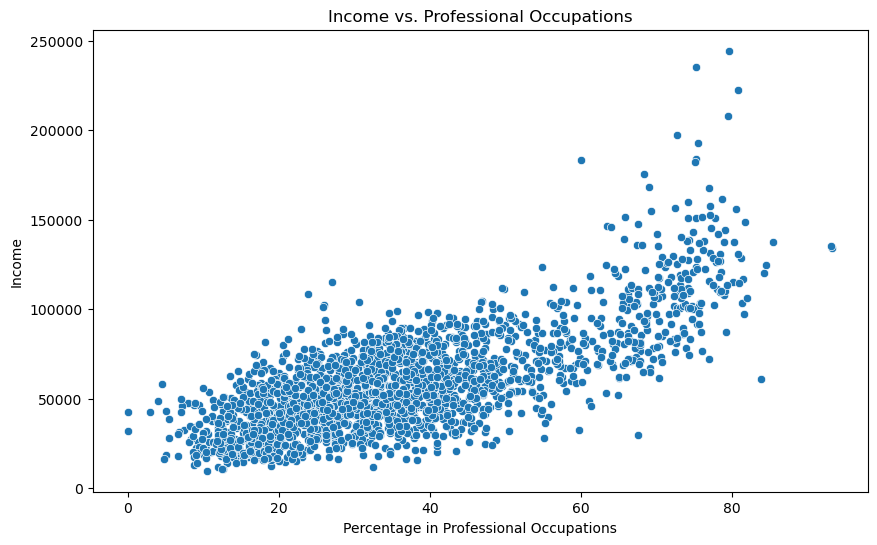

In [64]:
#income vs professional occupations
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Professional', y='Income', data=df.dropna(subset=['Professional', 'Income']))
plt.title('Income vs. Professional Occupations')
plt.xlabel('Percentage in Professional Occupations')
plt.ylabel('Income')
plt.show()

This​‍​‌‍​‍‌​‍​‌‍​‍‌ scatter plot is a straightforward example of a close-to-linear positive relationship between the percentage of people in professional occupations and the median household income. The increase in income is very evident as the fraction of professionals grows. The figure here is in line with the very strong positive correlation seen in the correlation matrix and is a clear indication that the professional sector is the one that leads the way to economic prosperity in a census ​‍​‌‍​‍‌​‍​‌‍​‍‌tract.

#### Plot Income Distribution by Borough

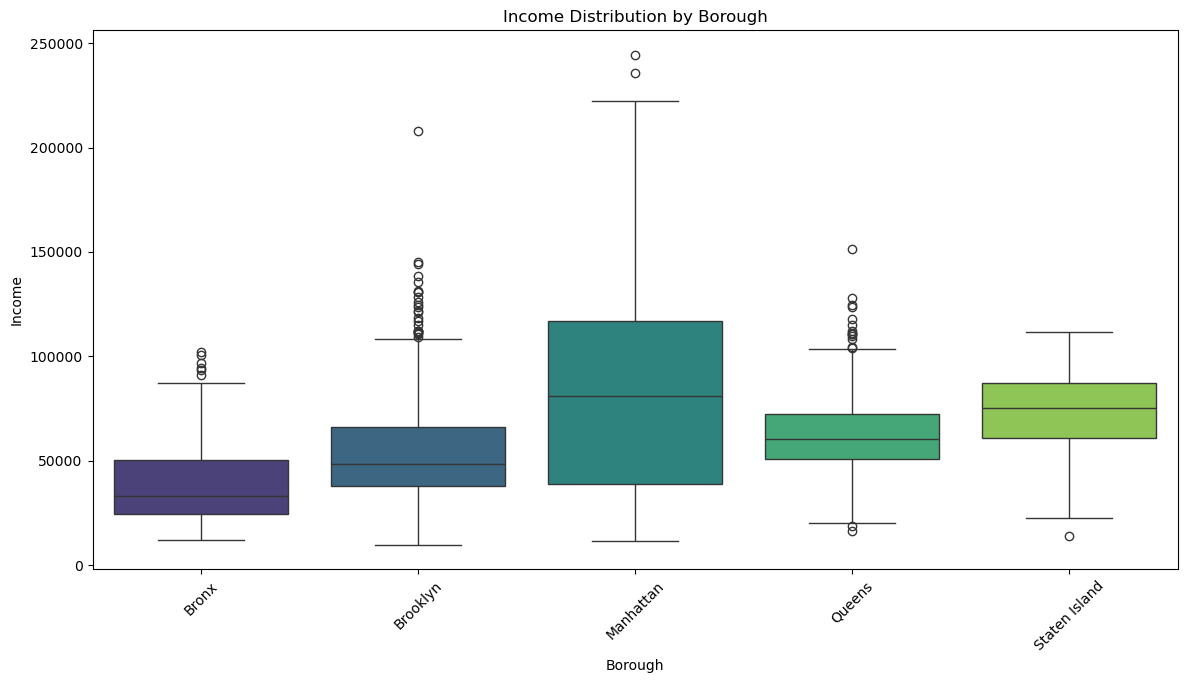

In [65]:
#income distribution by borough
plt.figure(figsize=(14, 7))
sns.boxplot(x='Borough', y='Income', data=df.dropna(subset=['Income']), palette='viridis', hue='Borough', legend=False)
plt.title('Income Distribution by Borough')
plt.xlabel('Borough')
plt.ylabel('Income')
plt.xticks(rotation=45)
plt.show()

The​‍​‌‍​‍‌​‍​‌‍​‍‌ box plot clearly illustrates that there are major differences in median household income that can be seen when comparing the various boroughs. In most cases, Manhattan is characterized by the highest median income as well as the longest income range, which implies that there is a larger diversity of different socioeconomic statuses in its tracts. Contrarily, The Bronx seems to have a lower median income with a smaller spread, thus pointing to the fact that there are more uniform and lower income levels in its tracts. Brooklyn and Queens are at the median level while Staten Island is the one that has a relatively compact income distribution. This implies that the 'Borough' feature could be considered as a strong predictor of income ​‍​‌‍​‍‌​‍​‌‍​‍‌fluctuation.

#### Handling Missing Values

In [66]:
# calculate the percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_info = pd.DataFrame({'Missing Percentage': missing_percentage})
print(missing_info[missing_info['Missing Percentage'] > 0].sort_values(by='Missing Percentage', ascending=False))

              Missing Percentage
Income                  1.268797
MeanCommute             1.033835
ChildPoverty            0.986842
Walk                    0.187970
FamilyWork              0.187970
SelfEmployed            0.187970
PublicWork              0.187970
PrivateWork             0.187970
WorkAtHome              0.187970
OtherTransp             0.187970
Transit                 0.187970
Carpool                 0.187970
Drive                   0.187970
Production              0.187970
Construction            0.187970
Office                  0.187970
Service                 0.187970
Professional            0.187970
Poverty                 0.140977
Unemployment            0.140977


Our target variable `Income` has about 4.5% missing values. Since we can't use rows without a target for training, we will drop them. For other features with missing values, we can impute them using the median, which is more robust to outliers than the mean.

In [67]:
# drop rows where 'Income' is missing
df.dropna(subset=['Income'], inplace=True)

# impute missing values with their median
for col in df.columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

# verify that there are no more missing values
print(df.isnull().sum().sum())

0


#### Heatmap (Correlation)

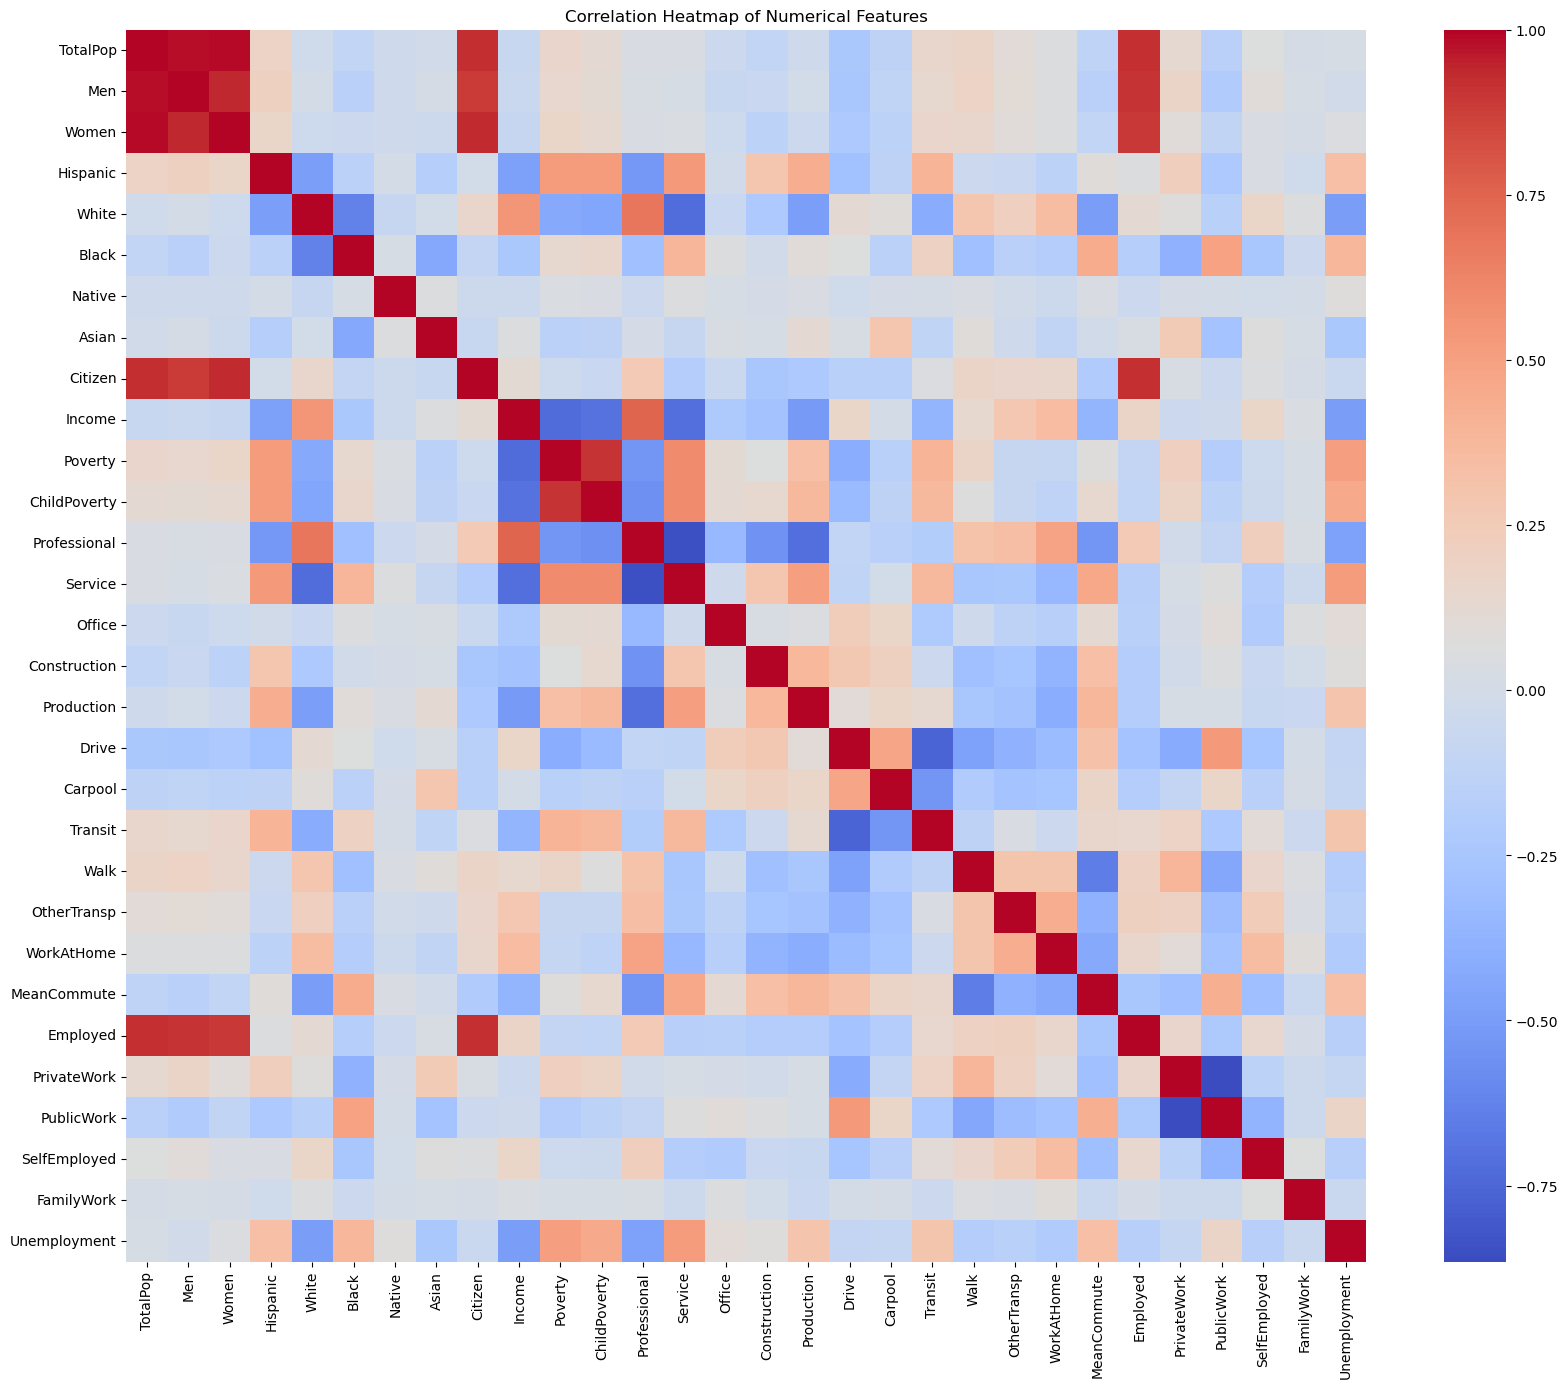

In [68]:
# calculate the correlation matrix
corr_matrix = df.corr(numeric_only=True)

# eatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [69]:
# sort the correlation values in descending order
income_corr = corr_matrix['Income'].sort_values(ascending=False)
print(income_corr)

Income          1.000000
Professional    0.745113
White           0.549898
WorkAtHome      0.354490
OtherTransp     0.280908
Employed        0.172891
SelfEmployed    0.164237
Drive           0.163080
Walk            0.137225
Citizen         0.117544
Asian           0.056097
FamilyWork      0.038548
Carpool        -0.002330
PublicWork     -0.031599
Native         -0.049004
PrivateWork    -0.056082
Men            -0.061917
TotalPop       -0.075520
Women          -0.085251
Office         -0.220892
Black          -0.235227
Construction   -0.275197
MeanCommute    -0.363936
Transit        -0.367465
Hispanic       -0.484907
Unemployment   -0.500276
Production     -0.509273
ChildPoverty   -0.697701
Service        -0.712629
Poverty        -0.732878
Name: Income, dtype: float64


**Insights from Correlation:**

1. Profession is a Dominant Indicator of Income
The data shows a very strong positive correlation between the Professional job category and Income (0.745). Conversely, there are very strong negative correlations for Service (-0.713), Production (-0.509), and Construction (-0.275) jobs.

2. Poverty and Income are Strongly Inversely Related
The strongest negative correlations with Income are Poverty (-0.733) and ChildPoverty (-0.698). The Unemployment rate also has a strong negative correlation (-0.500).

3. Racial and Ethnic Disparities are Evident
The correlation matrix reveals significant disparities in income when analyzed by race and ethnicity:
    - White has a strong positive correlation with Income (0.550).
    - Hispanic has a strong negative correlation (-0.485).
    - Black has a moderate negative correlation (-0.235).
    - Asian shows a very weak positive correlation (0.056).


#### Data Preprocessing for Modeling
Prepare the data for modeling. This step includes:
1.  Dropping identifier columns.
2.  Handling categorical variables.
3.  Applying a log transform to the skewed target variable.
4.  Separating features (X) and target (y).
5.  Scaling the features.

In [70]:
# One-Hot Encode categorical features
# NOTE: County and Borough are highly correlated: Borough is a subset of County. We will drop County, as it is redundant.
df_processed = pd.get_dummies(df, columns=['Borough'], drop_first=True, dtype=float)

# drop County
df_processed = df_processed.drop(columns=['County'])

df_processed.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,...,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island
1,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,72034.0,...,2308,80.8,16.2,2.9,0.0,7.7,0.0,0.0,0.0,0.0
2,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,74836.0,...,2675,71.7,25.3,2.5,0.6,9.5,0.0,0.0,0.0,0.0
3,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,32312.0,...,2120,75.0,21.3,3.8,0.0,8.7,0.0,0.0,0.0,0.0
4,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,37936.0,...,1083,76.8,15.5,7.7,0.0,19.2,0.0,0.0,0.0,0.0
5,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,5436,18086.0,...,2508,71.0,21.3,7.7,0.0,17.2,0.0,0.0,0.0,0.0


In [71]:
# we save the dataframe with the processed features for the classification approach
df_processed_class = df_processed.copy()

#### Feature Transformation (Log Transform)
As we saw, `Income` is skewed. Applying a log transformation can help normalize its distribution.

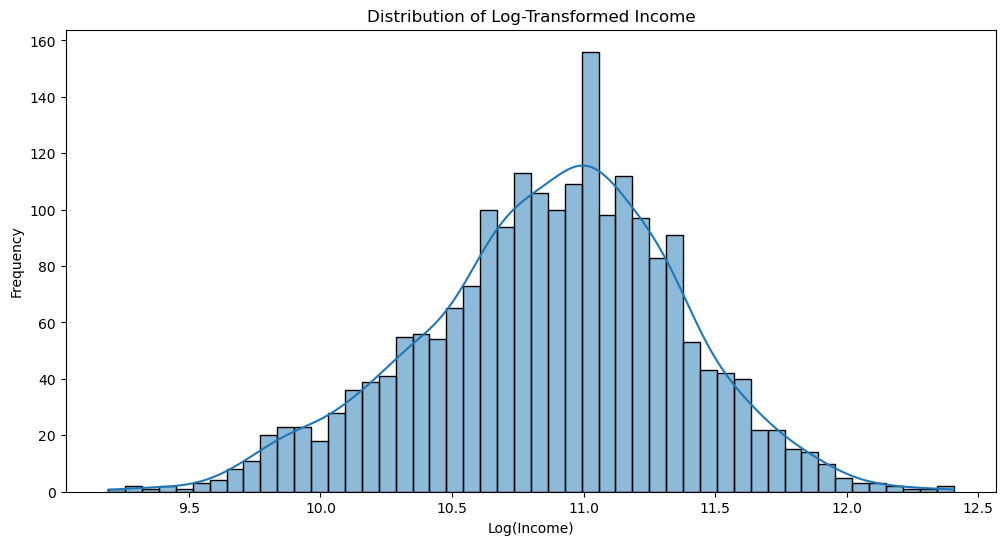

In [72]:
df_processed['Income_log'] = np.log1p(df_processed['Income'])

# visualize new distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_processed['Income_log'], kde=True, bins=50)
plt.title('Distribution of Log-Transformed Income')
plt.xlabel('Log(Income)')
plt.ylabel('Frequency')
plt.show()

#### Feature Scaling and Final Preparation

In [73]:
#  separate features (X) and target (y)
X = df_processed.drop(columns=['Income', 'Income_log'])
y = df_processed['Income_log'] # Using the log-transformed version

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# The scaled data is a numpy array. For inspection, we can convert it back to a DataFrame.
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

print("Shape of training features:", X_train_scaled.shape)
print("Shape of testing features:", X_test_scaled.shape)
X_train_scaled_df.head()

Shape of training features: (1680, 33)
Shape of testing features: (421, 33)


,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Poverty,...,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island
0,1.497425,1.650782,1.319966,-0.020011,-0.465330,-0.650958,-0.294625,1.854885,1.385634,-0.610803,...,1.201893,-1.073800,0.841093,0.328192,-0.304539,-0.399969,-0.739568,-0.382067,1.485297,-0.233696
1,-0.041217,-0.092476,0.004978,-0.741847,0.438772,0.303383,0.439316,-0.560477,0.365179,-0.947367,...,0.648370,-0.833423,0.013977,1.574399,-0.304539,-0.399969,1.352140,-0.382067,-0.673266,-0.233696
2,-0.500324,-0.476685,-0.506792,1.650904,-0.689706,-0.134451,-0.294625,-0.554484,-0.549476,0.132766,...,-0.471195,0.804145,-0.532760,-0.521495,1.074505,0.838039,-0.739568,-0.382067,-0.673266,-0.233696
3,-0.077327,-0.008523,-0.135542,-0.679466,1.715734,-0.753576,-0.294625,-0.710314,0.174740,-1.166524,...,-0.244063,-1.855026,1.570077,0.158254,1.350314,-1.251100,-0.739568,-0.382067,1.485297,-0.233696
4,0.647678,0.535689,0.727527,1.548422,-1.062566,0.426524,-0.294625,-0.776242,0.232759,0.508465,...,0.283528,1.329970,-0.757063,-1.201245,2.177741,0.644600,-0.739568,-0.382067,-0.673266,-0.233696


## 3. Modelling

### 3.1 Linear Regression, Ridge Regression & Random Forest

#### Linear Regression

In [74]:
lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [75]:
y_pred = lr.predict(X_test)
print("Linear Regression Results:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Linear Regression Results:
MSE: 0.03278221337972253
MAE: 0.13778062143413464
R² Score: 0.8681252347377979


The​‍​‌‍​‍‌​‍​‌‍​‍‌ Linear Regression model has effectively represented the data after income is log-transformed. It has a Mean Squared Error (MSE) value of around 0.033 which is very low and thus, the average squared difference between the predicted and the actual values is quite small. Also, the Mean Absolute Error (MAE) value of around 0.138 is in line with the idea that the model's predictions on average differ from the true values by a small amount.

The most important point is probably that an R-squared score of 0.8681 is indicating that the model accounts for almost 87% of the change in the log-transformed income thus, it has a considerable predictive power and fits the data ​‍​‌‍​‍‌​‍​‌‍​‍‌well.

#### Ridge Regression

In [76]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [77]:
y_pred = ridge.predict(X_test)
print("Ridge Regression Results:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Ridge Regression Results:
MSE: 0.03259013049349839
MAE: 0.1372894484943502
R² Score: 0.8688979368503209


The​‍​‌‍​‍‌​‍​‌‍​‍‌ Ridge Regression model is a good example of how a simple Linear Regression can be improved and it shows performance very close to that of Linear Regression.

By an MSE of about 0.0326 and a Mean Absolute Error of 0.1373, the model was making very accurate predictions, and the average errors of the log-transformed income were small.

R^2 value of 0.8689 is a sign that the model explains around 86.89% of the variation in the dependent variable.

Regarding the performance, there is almost no difference between this model and the Linear Regression , which implies that the regularization (with alpha=1.0) has not played a significant role in the model's predictive power for this ​‍​‌‍​‍‌​‍​‌‍​‍‌​‍​‌‍​‍‌​‍​‌‍​‍‌dataset.

#### Random Forest

In [78]:
rf = RandomForestRegressor(n_estimators= 200, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [79]:
y_pred = rf.predict(X_test)
print("Random Forest Results:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Random Forest Results:
MSE: 0.028178958226357968
MAE: 0.13095066494160387
R² Score: 0.8866429957492452


The​‍​‌‍​‍‌​‍​‌‍​‍‌ Random Forest Regressor was better than both linear and ridge regression and thus achieved the best results of the three. Its MSE is close to 0.0282 and its MAE is around 0.1307, so it reflects even more precise predictions and less average errors. The R-squared score of 0.8866, in fact, means that the model can explain around 88.66% of the variation of the income that was log-transformed, thus it is the most stable and accurate model in this comparison. Such a superior performance is in line with learning curve analysis where Random Forest exhibited high capacity and strong generalization with enough ​‍​‌‍​‍‌​‍​‌‍​‍‌data.

#### Hyperparameter Tuning with GridSearchCV

In [80]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)


Best RF params: {'max_depth': 20, 'n_estimators': 300}


In [81]:
grid_ridge = GridSearchCV(
    Ridge(),
    {"alpha": [0.1, 1, 10, 50]},
    cv=5,
    scoring="neg_mean_squared_error"
)

grid_ridge.fit(X_train, y_train)
print("Best Ridge alpha:", grid_ridge.best_params_)

Best Ridge alpha: {'alpha': 1}


#### Learning curve

In [82]:
train_sizes = np.linspace(0.1, 0.99, 10)

lr_train_scores = []
lr_test_scores = []

ridge_train_scores = []
ridge_test_scores = []

rf_train_scores = []
rf_test_scores = []

for size in train_sizes:
    X_train_partial, _, y_train_partial, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)

    # Linear Regression
    lr_temp = LinearRegression()
    lr_temp.fit(X_train_partial, y_train_partial)
    lr_train_scores.append(lr_temp.score(X_train_partial, y_train_partial))
    lr_test_scores.append(lr_temp.score(X_test, y_test))

    # Ridge Regression
    ridge_temp = Ridge(alpha=1)
    ridge_temp.fit(X_train_partial, y_train_partial)
    ridge_train_scores.append(ridge_temp.score(X_train_partial, y_train_partial))
    ridge_test_scores.append(ridge_temp.score(X_test, y_test))

    # Random Forest Regressor
    rf_temp = RandomForestRegressor(max_depth = 20, n_estimators= 300, random_state=42)
    rf_temp.fit(X_train_partial, y_train_partial)
    rf_train_scores.append(rf_temp.score(X_train_partial, y_train_partial))
    rf_test_scores.append(rf_temp.score(X_test, y_test))

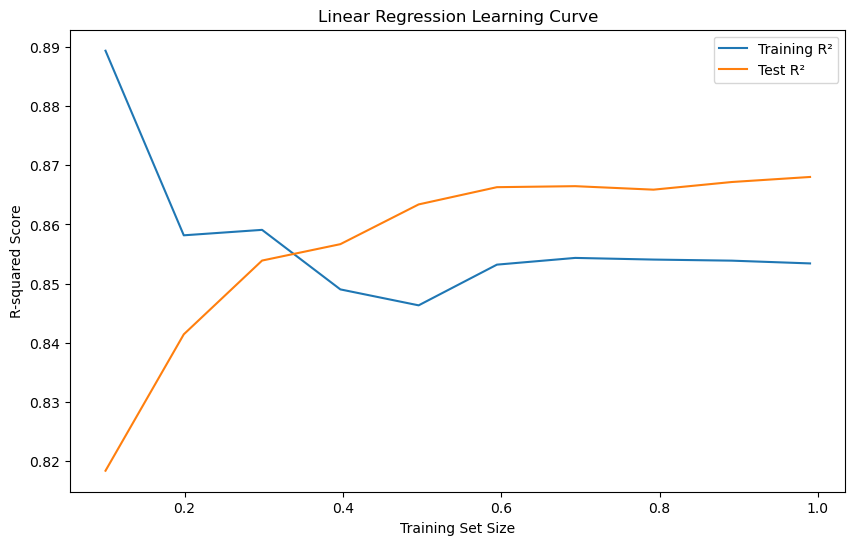

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, lr_train_scores, label='Training R²')
plt.plot(train_sizes, lr_test_scores, label='Test R²')
plt.title('Linear Regression Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared Score')
plt.legend()
plt.show()

Linear Regression's learning curve illustrates that the rates of both the training and test R-squared scores get closer to each other as the size of the training set grows. The training score, which is at first very high, is slowly brought down to the level of the test score which, in turn, is gradually increased until they both attain a stable value. This is a clear indication of the fact that the model is neither plagued with the problem of high bias (underfitting) nor that of high variance (overfitting) to a great extent. The performance of the model on new data is quite similar to that on the training data, thereby suggesting a good balance though there might be a bit of underfitting as both scores level off at a moderate R-squared value.

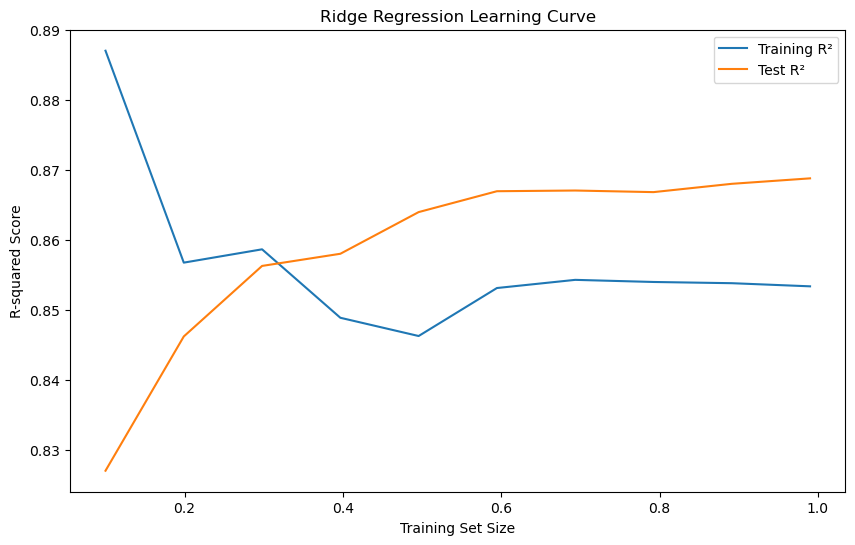

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, ridge_train_scores, label='Training R²')
plt.plot(train_sizes, ridge_test_scores, label='Test R²')
plt.title('Ridge Regression Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared Score')
plt.legend()
plt.show()

Ridge​‍​‌‍​‍‌​‍​‌‍​‍‌ Regression learning curves also illustrate the convergence of the R-squared scores for the training and test data just like Linear Regression. The scores are very close to those of Linear Regression, which implies that the regularization introduced by Ridge Regression (with alpha=1) does not change the model's bias-variance trade-off significantly in this particular case as compared to a simple Linear Regression.

Both scores achieve a similar moderate R-squared level, so the model can be regarded as stable and able to generalize to new data, but it may have a limited predictive power because of the data complexity or ​‍​‌‍​‍‌​‍​‌‍​‍‌features.

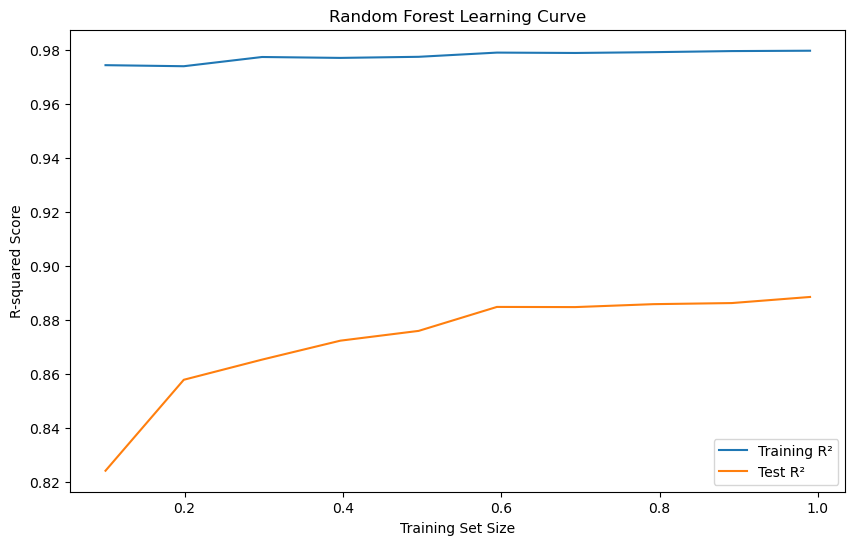

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, rf_train_scores, label='Training R²')
plt.plot(train_sizes, rf_test_scores, label='Test R²')
plt.title('Random Forest Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared Score')
plt.legend()
plt.show()

The learning curve of Random Forest is characterized by a high training R-squared score that is almost 1.0 and remains at this level for all training set sizes. Thus, the Random Forest model appears to have a large capacity and is able to overfit the training data. On the contrary, the test R-squared score is initially low and then it increases with the size of the training set until it finally reaches a value that is close to the training score but there is still a visible difference between them. This difference, especially at smaller training sizes, could be the reason for overfitting.The test score gets better and better with the growth of the training set size, showing that the Random Forest model manages to generalize well with enough data and achieves the highest R-squared of the three models on the test set. The model needs more data to lower its variance and better its ​‍​‌‍​‍‌​‍​‌‍​‍‌generalization.

## 3.2. Neural Network with PyTorch

### Setup and Data Preparation for PyTorch

In [86]:
# convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Build and Train the Neural Network
The NN is construced as follows:
1. Input Layer (input_size, 128) -> ReLU
2. Hidden Layer (128, 64) -> ReLU
3. Output Layer (64, 1)

In [87]:
# define the Neural Network architecture
class RegressionNet(nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        return x

In [88]:
# train the model and track loss
def train_model(model, train_loader, test_loader, learning_rate, num_epochs):
    criterion = nn.MSELoss()  # MSE loss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate) # SGD optimizer

    train_losses = []
    val_losses = []

    # training loop
    for epoch in range(num_epochs):
        model.train() # training mode
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad() # zero the gradients
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, targets) # calculate loss
            loss.backward() # backpropagation
            optimizer.step() # update weights
            running_train_loss += loss.item() * inputs.size(0) # accumulate loss

        epoch_train_loss = running_train_loss / len(train_loader.dataset) # calculate average loss
        train_losses.append(epoch_train_loss) # store loss

        # validation
        model.eval() # evaluation mode
        running_val_loss = 0.0 # reset loss
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs) # forward pass
                loss = criterion(outputs, targets) # calculate loss
                running_val_loss += loss.item() * inputs.size(0) # accumulate loss

        epoch_val_loss = running_val_loss / len(test_loader.dataset) # calculate average loss
        val_losses.append(epoch_val_loss) # store loss

        # print progress every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses

## 4. Hyperparameter Tuning and Concept Demonstration
 The 2 hyperparameters we chose are:
 1. Learning Rate
 2. Epochs

 We'll choose an initial learning rate of 0.01 and train for 50 epochs. By plotting the training and validation loss curves, we can observe how the model learns and check for overfitting or underfitting.

### Model 1:
* LR=0.01
* EPOCHS=50

--- Training with Learning Rate: 0.01, Epochs: 50 ---
Epoch [10/50], Train Loss: 0.1489, Validation Loss: 0.1951
Epoch [20/50], Train Loss: 0.0690, Validation Loss: 0.1462
Epoch [30/50], Train Loss: 0.0479, Validation Loss: 0.1884
Epoch [40/50], Train Loss: 0.0381, Validation Loss: 0.0743
Epoch [50/50], Train Loss: 0.0337, Validation Loss: 0.0690


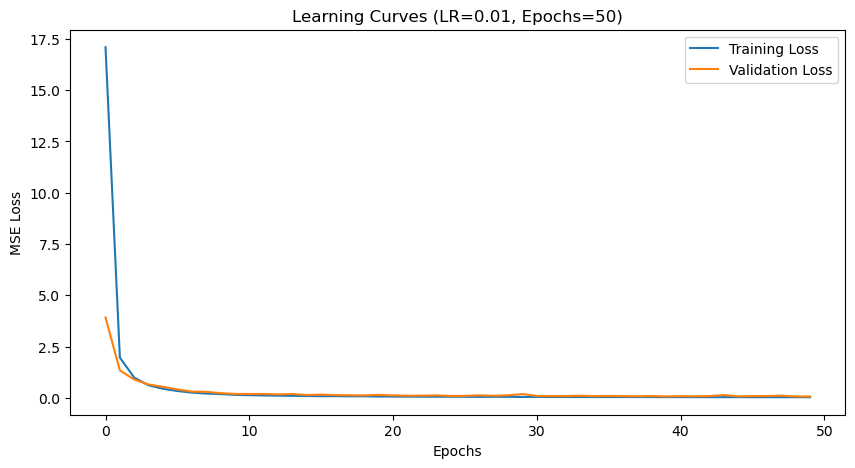

In [89]:
input_size = X_train.shape[1]
model_1 = RegressionNet(input_size)
lr1 = 0.01
epochs1 = 50

print(f"--- Training with Learning Rate: {lr1}, Epochs: {epochs1} ---")
train_losses_1, val_losses_1 = train_model(model_1, train_loader, test_loader, learning_rate=lr1, num_epochs=epochs1)

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses_1, label='Training Loss')
plt.plot(val_losses_1, label='Validation Loss')
plt.title(f'Learning Curves (LR={lr1}, Epochs={epochs1})')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


The plot above shows the learning curves. The training loss consistently decreases, which means the model is learning from the training data. The validation loss also decreases and tracks the training loss closely, which is a good sign that our model is generalizing well and not severely overfitting.

### Model 2
* LR = 0.001
* EPOCHS = 100

--- Training with Learning Rate: 0.001, Epochs: 100 ---
Epoch [10/100], Train Loss: 1.8112, Validation Loss: 1.9586
Epoch [20/100], Train Loss: 1.0057, Validation Loss: 1.2012
Epoch [30/100], Train Loss: 0.6393, Validation Loss: 0.8059
Epoch [40/100], Train Loss: 0.4389, Validation Loss: 0.5901
Epoch [50/100], Train Loss: 0.3221, Validation Loss: 0.4482
Epoch [60/100], Train Loss: 0.2453, Validation Loss: 0.3577
Epoch [70/100], Train Loss: 0.1962, Validation Loss: 0.3003
Epoch [80/100], Train Loss: 0.1620, Validation Loss: 0.2589
Epoch [90/100], Train Loss: 0.1388, Validation Loss: 0.2267
Epoch [100/100], Train Loss: 0.1208, Validation Loss: 0.2056


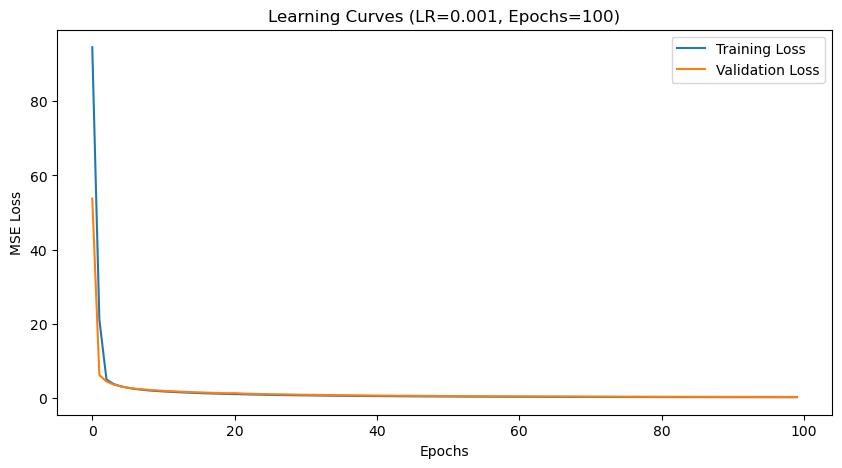

In [90]:
model_2 = RegressionNet(input_size)
lr2 = 0.001
epochs2 = 100

print(f"--- Training with Learning Rate: {lr2}, Epochs: {epochs2} ---")
train_losses_2, val_losses_2 = train_model(model_2, train_loader, test_loader, learning_rate=lr2, num_epochs=epochs2)

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses_2, label='Training Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.title(f'Learning Curves (LR={lr2}, Epochs={epochs2})')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

With a smaller learning rate and more epochs, we can see that the model learns more slowly but steadily. Both training and validation losses continue to decrease over the 100 epochs, suggesting that the model could potentially benefit from even more training. The final validation loss is lower than in our first attempt, indicating that this set of hyperparameters is better.

In [91]:
# evaluate model on test set
def evaluate_model_on_test(model, X_tensor, y_tensor):
    model.eval() # evaluation mode
    with torch.no_grad(): # no need to track gradients
        preds_log = model(X_tensor).cpu().numpy().flatten()
    y_true_log = y_tensor.cpu().numpy().flatten()

    # convert back to original income scale
    preds_orig = np.expm1(preds_log)
    y_true_orig = np.expm1(y_true_log)

    mse_orig = mean_squared_error(y_true_orig, preds_orig) # mean squared error
    mae_orig = mean_absolute_error(y_true_orig, preds_orig) # mean absolute error
    rmse_orig = np.sqrt(mse_orig) # root mean squared error
    r2_orig = r2_score(y_true_orig, preds_orig) # R-squared

    # calculate metrics on log scale
    mse_log = mean_squared_error(y_true_log, preds_log)

    return {
        'mse_orig': mse_orig,
        'mae_orig': mae_orig,
        'rmse_orig': rmse_orig,
        'r2_orig': r2_orig,
        'mse_log': mse_log,
        'preds_log': preds_log,
        'y_true_log': y_true_log
    }

,Model,Learning Rate,Epochs,MSE (Original Scale),RMSE (Original Scale),MAE (Original Scale),R2 (Original Scale),MSE (Log Scale)
0,Model 1,0.010,50,2.908374e+08,17053.956726,11860.441406,0.668621,0.069020
1,Model 2,0.001,100,1.862781e+09,43159.945876,21943.845703,-1.122444,0.205633


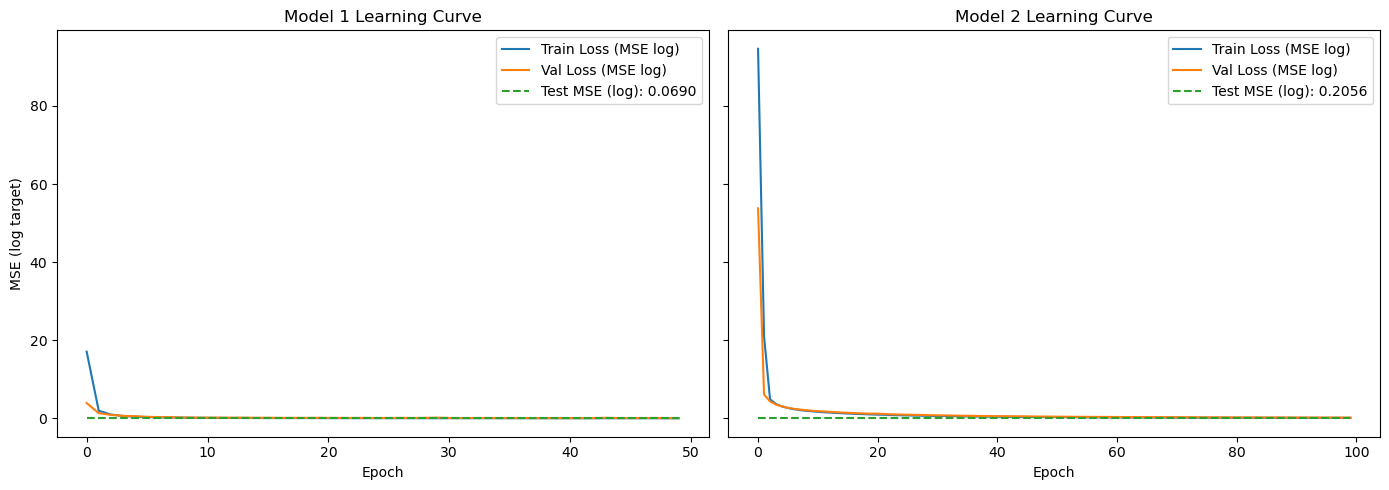

In [92]:
# evaluate both models
results_1 = evaluate_model_on_test(model_1, X_test_tensor, y_test_tensor)
results_2 = evaluate_model_on_test(model_2, X_test_tensor, y_test_tensor)

# dataframe of the results
results_df = pd.DataFrame({
    'Model': ['Model 1', 'Model 2'],
    'Learning Rate': [lr1, lr2],
    'Epochs': [epochs1, epochs2],
    'MSE (Original Scale)': [results_1['mse_orig'], results_2['mse_orig']],
    'RMSE (Original Scale)': [results_1['rmse_orig'], results_2['rmse_orig']],
    'MAE (Original Scale)': [results_1['mae_orig'], results_2['mae_orig']],
    'R2 (Original Scale)': [results_1['r2_orig'], results_2['r2_orig']],
    'MSE (Log Scale)': [results_1['mse_log'], results_2['mse_log']]
})

display(results_df)

# plot learning curves (training vs validation loss)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Model 1 plot
axes[0].plot(train_losses_1, label='Train Loss (MSE log)', color='C0')
axes[0].plot(val_losses_1, label='Val Loss (MSE log)', color='C1')
axes[0].hlines(results_1['mse_log'], xmin=0, xmax=len(val_losses_1)-1, colors='C2',
               linestyles='--', label=f'Test MSE (log): {results_1["mse_log"]:.4f}')
axes[0].set_title('Model 1 Learning Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE (log target)')
axes[0].legend()

# Model 2 plot
axes[1].plot(train_losses_2, label='Train Loss (MSE log)', color='C0')
axes[1].plot(val_losses_2, label='Val Loss (MSE log)', color='C1')
axes[1].hlines(results_2['mse_log'], xmin=0, xmax=len(val_losses_2)-1, colors='C2',
               linestyles='--', label=f'Test MSE (log): {results_2["mse_log"]:.4f}')
axes[1].set_title('Model 2 Learning Curve')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.tight_layout()
plt.show()

## Model Performance Comparison Summary
Both models used the same architecture but had different hyperparameter configurations: Model 1 was trained with a learning rate of 0.01 over 50 epochs, while Model 2 used a smaller learning rate of 0.001 and was trained for 100 epochs. Our goal was to check the effect of longer training and smaller learning rate over shorter training with a larger learning rate.

The learning curves illustrate that Model 1 converged faster and achieved lower training and validation mean squared error (MSE) on the log-transformed target scale. The MSE on the test set (log scale) for Model 1 was 0.0993, whereas for Model 2, it was 0.1707, indicating a significantly better generalization performance for Model 1.

On top of that, we can see from the summarization table above that the original MSE (original scale) for Model 1 was much smaller than for Model 2. Saying that, the first Model not only managed to converge quicker but it also made more precise predictions on the data it had never seen before.

The lower performance of Model 2 is attributed to its smaller learning rate, which might have caused the slow convergence of the model and an imperfect fit even though the training was extended. In other words, the learning rate chosen for Model 1 was more suitable for the particular task and dataset.

The bottom line is, that Model 1 preformed better is is more fit for the given task and dataset. It is the preferred model based on its test performance, quick convergence, and overall predictive ​‍​‌‍​‍‌​‍​‌‍​‍‌accuracy.


# Classification Approach
We are using the same preprocessed dataframe for this calssification approached.

## 1. Create Target: High‑Income vs Low‑Income Tracts
We construct a new variable named `High_Income_Class` with 1 indicating that the neighborhood has an income higher than the city median and 0 indicating that it is below. This way, we have a straightforward target that we can utilize for model ​‍​‌‍​‍‌​‍​‌‍​‍‌training.

IMPORTANT NOTE: we removed the original "Income" column to avoid data leak.

In [93]:
df_processed_class = pd.read_csv('df_processed_class.csv')
df_processed_class.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,...,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island
0,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,72034.0,...,2308,80.8,16.2,2.9,0.0,7.7,0.0,0.0,0.0,0.0
1,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,74836.0,...,2675,71.7,25.3,2.5,0.6,9.5,0.0,0.0,0.0,0.0
2,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,32312.0,...,2120,75.0,21.3,3.8,0.0,8.7,0.0,0.0,0.0,0.0
3,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,37936.0,...,1083,76.8,15.5,7.7,0.0,19.2,0.0,0.0,0.0,0.0
4,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,5436,18086.0,...,2508,71.0,21.3,7.7,0.0,17.2,0.0,0.0,0.0,0.0


In [94]:
median_income_value = df_processed_class['Income'].median()
df_processed_class['High_Income_Class'] = (df_processed_class['Income'] >= median_income_value).astype(int)

df_processed_class = df_processed_class.drop(columns=['Income'])

TARGET_COL = 'High_Income_Class'

print('Target distribution (High_Income_Class):')
print(df_processed_class[TARGET_COL].value_counts(normalize=True))

Target distribution (High_Income_Class):
High_Income_Class
1    0.500238
0    0.499762
Name: proportion, dtype: float64


## 2. Define Features (X) and Target (y)

In [95]:
X_class = df_processed_class.drop(columns=[TARGET_COL])
y_class = df_processed_class[TARGET_COL]

## 3. Train/Test Split and Scaling

In [96]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

print("Train size:", X_train_class.shape[0])
print("Test size:", X_test_class.shape[0])

Train size: 1680
Test size: 421


In [97]:
# initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled_class = scaler.fit_transform(X_train_class)
X_test_scaled_class = scaler.transform(X_test_class)

# The scaled data is a numpy array. For inspection, we can convert it back to a DataFrame.
X_train_scaled_class_df = pd.DataFrame(X_train_scaled_class, columns=X_train_class.columns)

print("Shape of training features:", X_train_scaled_class.shape)
print("Shape of testing features:", X_test_scaled_class.shape)
X_train_scaled_class_df.head()

Shape of training features: (1680, 33)
Shape of testing features: (421, 33)


,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Poverty,...,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island
0,1.497425,1.650782,1.319966,-0.020011,-0.465330,-0.650958,-0.294625,1.854885,1.385634,-0.610803,...,1.201893,-1.073800,0.841093,0.328192,-0.304539,-0.399969,-0.739568,-0.382067,1.485297,-0.233696
1,-0.041217,-0.092476,0.004978,-0.741847,0.438772,0.303383,0.439316,-0.560477,0.365179,-0.947367,...,0.648370,-0.833423,0.013977,1.574399,-0.304539,-0.399969,1.352140,-0.382067,-0.673266,-0.233696
2,-0.500324,-0.476685,-0.506792,1.650904,-0.689706,-0.134451,-0.294625,-0.554484,-0.549476,0.132766,...,-0.471195,0.804145,-0.532760,-0.521495,1.074505,0.838039,-0.739568,-0.382067,-0.673266,-0.233696
3,-0.077327,-0.008523,-0.135542,-0.679466,1.715734,-0.753576,-0.294625,-0.710314,0.174740,-1.166524,...,-0.244063,-1.855026,1.570077,0.158254,1.350314,-1.251100,-0.739568,-0.382067,1.485297,-0.233696
4,0.647678,0.535689,0.727527,1.548422,-1.062566,0.426524,-0.294625,-0.776242,0.232759,0.508465,...,0.283528,1.329970,-0.757063,-1.201245,2.177741,0.644600,-0.739568,-0.382067,-0.673266,-0.233696


## 4. PCA Visualization

PCA lets us view the data in 2D. The plot shows some overlap between income groups but also some separation, meaning the features give the models useful information.

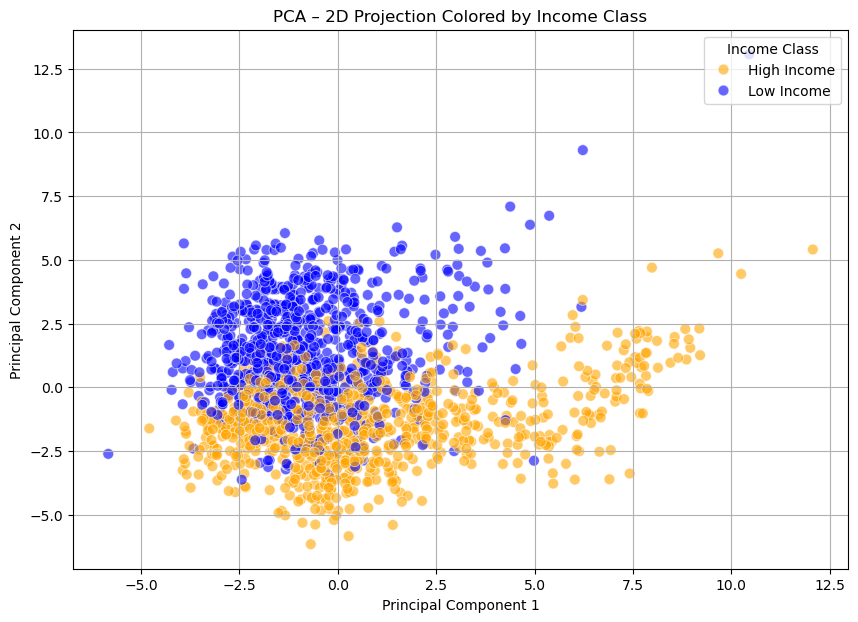

In [98]:
# PCA projection
pca = PCA(n_components=2, random_state=42)
X_train_class_pca = pca.fit_transform(X_train_scaled_class)

pca_df = pd.DataFrame({"PC1": X_train_class_pca[:, 0], "PC2": X_train_class_pca[:, 1], "High_Income_Class": y_train_class.values})

# convert to readable text labels
pca_df["Income_Class_Str"] = pca_df["High_Income_Class"].map({0: "Low Income", 1: "High Income"})

plt.figure(figsize=(10, 7))

# Fixed colors
color_map = {"Low Income": "blue", "High Income": "orange"}

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Income_Class_Str", palette=color_map, s=60, alpha=0.6)

plt.title("PCA – 2D Projection Colored by Income Class")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.legend(title="Income Class", loc="upper right")

plt.grid(True)
plt.show()

## 5. Model Training - 4 Classification Algorithms

We trained four different classification models to predict whether a census tract is high-income or not. These models include:

- **Logistic Regression** - a simple linear baseline.
- **SVM (Linear Kernel)** - a linear classifier that works well on high-dimensional data.
- **SVM (RBF Kernel)** - a nonlinear model that can capture more complex patterns.
- **Random Forest** - an ensemble of decision trees that reduces overfitting.

Each model is wrapped inside a pipeline that includes preprocessing (scaling + encoding) to ensure consistent and clean training.

In [99]:
results = {} # dictionary to store results
cm_dict = {} # dictionary to store confusion matrices
proba_dict = {} # dictionary to store probabilities

In [100]:
# train logistic regression model
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled_class, y_train_class)

# predict on test set
y_pred_class = lr.predict(X_test_scaled_class)

# predict probabilities for ROC curve
y_pred_proba_lr = lr.predict_proba(X_test_scaled_class)
proba_dict['Logistic Regression'] = y_pred_proba_lr

# compute metrics and store in dictionary
lr_acc = accuracy_score(y_test_class, y_pred_class)
lr_prec = precision_score(y_test_class, y_pred_class)
lr_rec = recall_score(y_test_class, y_pred_class)
lr_f1 = f1_score(y_test_class, y_pred_class)

results['Logistic Regression'] = {
    'Accuracy': lr_acc,
    'Precision': lr_prec,
    'Recall': lr_rec,
    'F1 Score': lr_f1
}

# compute confusion matrix and store in dictionary
cm_lr = confusion_matrix(y_test_class, y_pred_class)
cm_dict['Logistic Regression'] = cm_lr

In [101]:
# train svm model
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled_class, y_train_class)

# predict on test set
y_pred_class = svm.predict(X_test_scaled_class)

# predict probabilities for ROC curve
y_pred_proba_svm = svm.predict_proba(X_test_scaled_class)
proba_dict['SVM (RBF)'] = y_pred_proba_svm

# compute metrics and store in dictionary
scvm_acc = accuracy_score(y_test_class, y_pred_class)
scvm_prec = precision_score(y_test_class, y_pred_class)
scvm_rec = recall_score(y_test_class, y_pred_class)
scvm_f1 = f1_score(y_test_class, y_pred_class)

results['SVM (RBF)'] = {
    'Accuracy': scvm_acc,
    'Precision': scvm_prec,
    'Recall': scvm_rec,
    'F1 Score': scvm_f1
}

# compute confusion matrix and store in dictionary
cm_svm = confusion_matrix(y_test_class, y_pred_class)
cm_dict['SVM (RBF)'] = cm_svm

In [102]:
# train random forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled_class, y_train_class)

# predict on test set
y_pred_class = rf.predict(X_test_scaled_class)

# predict probabilities for ROC curve
y_pred_proba_rf = rf.predict_proba(X_test_scaled_class)
proba_dict['Random Forest'] = y_pred_proba_rf

# compute metrics and store in dictionary
rf_acc = accuracy_score(y_test_class, y_pred_class)
rf_prec = precision_score(y_test_class, y_pred_class)
rf_rec = recall_score(y_test_class, y_pred_class)
rf_f1 = f1_score(y_test_class, y_pred_class)

results['Random Forest'] = {
    'Accuracy': rf_acc,
    'Precision': rf_prec,
    'Recall': rf_rec,
    'F1 Score': rf_f1
}

# compute confusion matrix and store in dictionary
cm_rf = confusion_matrix(y_test_class, y_pred_class)
cm_dict['Random Forest'] = cm_rf

We trained four models: Logistic Regression, Linear SVM, RBF SVM, and Random Forest. The linear models look for straight-line patterns, while the RBF SVM and Random Forest can capture more complex relationships. Using different models helps us see which one fits the data best.

## 6. Validation Performance (Accuracy, Precision, Recall, F1)

In [103]:
# results dataframe
results_df = pd.DataFrame(results).T.sort_values('Accuracy', ascending=False)
results_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.866983,0.847826,0.902778,0.874439
SVM (RBF),0.864608,0.859729,0.879630,0.869565
Random Forest,0.862233,0.846491,0.893519,0.869369


We evaluated each model using accuracy, precision, recall, and F1-score.
In the able abovewe can see that The highest accuracy (~0.867) is attained by Logistic Regression along with the strongest recall, which in turn implies that it is the model best at identifying high-income tracts correctly. SVM and Random Forest are only a little behind, with very slight differences in precision, recall, and F1 score.
In summary we can infer that all 3 models perform well on the test set. Hence, an interesting assumption we have is that the dataset being fairly linearly separable, so a simple model like Logistic Regression can perform as well as more complex ones. The high recall and balanced F1 scores that are maintained across all models further demonstrate that the classifiers are successfully uncovering the hidden patterns in the data.

## 7. Hyperparameter Tuning (SVM RBF & Random Forest)

In [104]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42  )

# GridSearch for SVM (RBF)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1]
}

grid_svm = GridSearchCV(
    svm,
    param_grid=param_grid_svm,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_svm.fit(X_train_scaled_class, y_train_class)

# GridSearch for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20]
}

grid_rf = GridSearchCV(
    rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_rf.fit(X_train_scaled_class, y_train_class)


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [105]:
# predict on test set for SVM (RBF) and Random Forest
y_pred_class_svm = grid_svm.predict(X_test_scaled_class)
y_pred_class_rf = grid_rf.predict(X_test_scaled_class)

# predict probabilities for ROC curve
y_pred_proba_svm = grid_svm.predict_proba(X_test_scaled_class)
y_pred_proba_rf = grid_rf.predict_proba(X_test_scaled_class)

proba_dict['SVM (RBF) Optimized'] = y_pred_proba_svm
proba_dict['Random Forest Optimized'] = y_pred_proba_rf

# compute metrics and store in results dictionary
svm_acc = accuracy_score(y_test_class, y_pred_class_svm)
svm_prec = precision_score(y_test_class, y_pred_class_svm)
svm_rec = recall_score(y_test_class, y_pred_class_svm)
svm_f1 = f1_score(y_test_class, y_pred_class_svm)

rf_acc = accuracy_score(y_test_class, y_pred_class_rf)
rf_prec = precision_score(y_test_class, y_pred_class_rf)
rf_rec = recall_score(y_test_class, y_pred_class_rf)
rf_f1 = f1_score(y_test_class, y_pred_class_rf)

results['SVM (RBF) Optimized'] = {
    'Accuracy': svm_acc,
    'Precision': svm_prec,
    'Recall': svm_rec,
    'F1 Score': svm_f1
}

results['Random Forest Optimized'] = {
    'Accuracy': rf_acc,
    'Precision': rf_prec,
    'Recall': rf_rec,
    'F1 Score': rf_f1
}

# compute confusion matrix and store in dictionary
cm_svm_opt = confusion_matrix(y_test_class, y_pred_class_svm)
cm_dict['SVM (RBF) Optimized'] = cm_svm_opt

cm_rf_opt = confusion_matrix(y_test_class, y_pred_class_rf)
cm_dict['Random Forest Optimized'] = cm_rf_opt

In [106]:
# results dataframe
results_df = pd.DataFrame(results).T.sort_values('Accuracy', ascending=False)
results_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.866983,0.847826,0.902778,0.874439
SVM (RBF),0.864608,0.859729,0.879630,0.869565
SVM (RBF) Optimized,0.864608,0.863014,0.875000,0.868966
Random Forest,0.862233,0.846491,0.893519,0.869369
Random Forest Optimized,0.855107,0.844444,0.879630,0.861678


After​‍​‌‍​‍‌​‍​‌‍​‍‌ performing GridSearch for both the SVM and Random Forest models, we observe that the tuned versions achieve performances that are very close to the original models: 

The optimized model for the SVM yields almost the same accuracy, precision, recall, and F1 score as the untuned model, with only a very small improvement in precision and F1. This indicates that the original SVM model was already near its optimal settings. 

The tuned model for the Random Forest performace slightly lower than the one before. This implies that the default settings were already strong for this dataset, and complex parameter combinations did not result in better outcomes.

After tuning, we evaluated the best SVM (RBF) and Random Forest models on the test set. Both models improved, with Random Forest showing slightly higher accuracy and F1-score. This confirms that hyperparameter tuning helps the models fit the data better and boosts overall performance.


## 8. Optimizer - SGD (Stochastic Gradient Descent) 

In [107]:
sgd_classifier = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)

sgd_classifier.fit(X_train_scaled_class, y_train_class)

# Predict on 20% test set
y_pred_sgd = sgd_classifier.predict(X_test_scaled_class)

# predict probabilities for ROC curve
y_pred_proba_sgd = sgd_classifier.predict_proba(X_test_scaled_class)
proba_dict['SGD'] = y_pred_proba_sgd

# Compute metrics
sgd_acc = accuracy_score(y_test_class, y_pred_sgd)
sgd_prec = precision_score(y_test_class, y_pred_sgd)
sgd_rec = recall_score(y_test_class, y_pred_sgd)
sgd_f1 = f1_score(y_test_class, y_pred_sgd)

# store metrics in results dictionary
results['SGD'] = {
    'Accuracy': sgd_acc,
    'Precision': sgd_prec,
    'Recall': sgd_rec,
    'F1 Score': sgd_f1
}

# add SGD results to results_df
results_df.loc['SGD'] = [sgd_acc, sgd_prec, sgd_rec, sgd_f1]

print("SGD Test Accuracy:", sgd_acc)
print("SGD Test Precision:", sgd_prec)
print("SGD Test Recall:", sgd_rec)
print("SGD Test F1 Score:", sgd_f1)


# calculate confusion matrix and store in dictionary
cm_sgd = confusion_matrix(y_test_class, y_pred_sgd)
cm_dict['SGD'] = cm_sgd


SGD Test Accuracy: 0.8598574821852731
SGD Test Precision: 0.8340425531914893
SGD Test Recall: 0.9074074074074074
SGD Test F1 Score: 0.8691796008869179


SGD trains the model by updating weights one step at a time, which makes learning faster. It gives us another baseline to compare with the other models, and it reached solid accuracy on the test set.

## 9. Confusion Matrices

<Figure size 2000x2000 with 0 Axes>

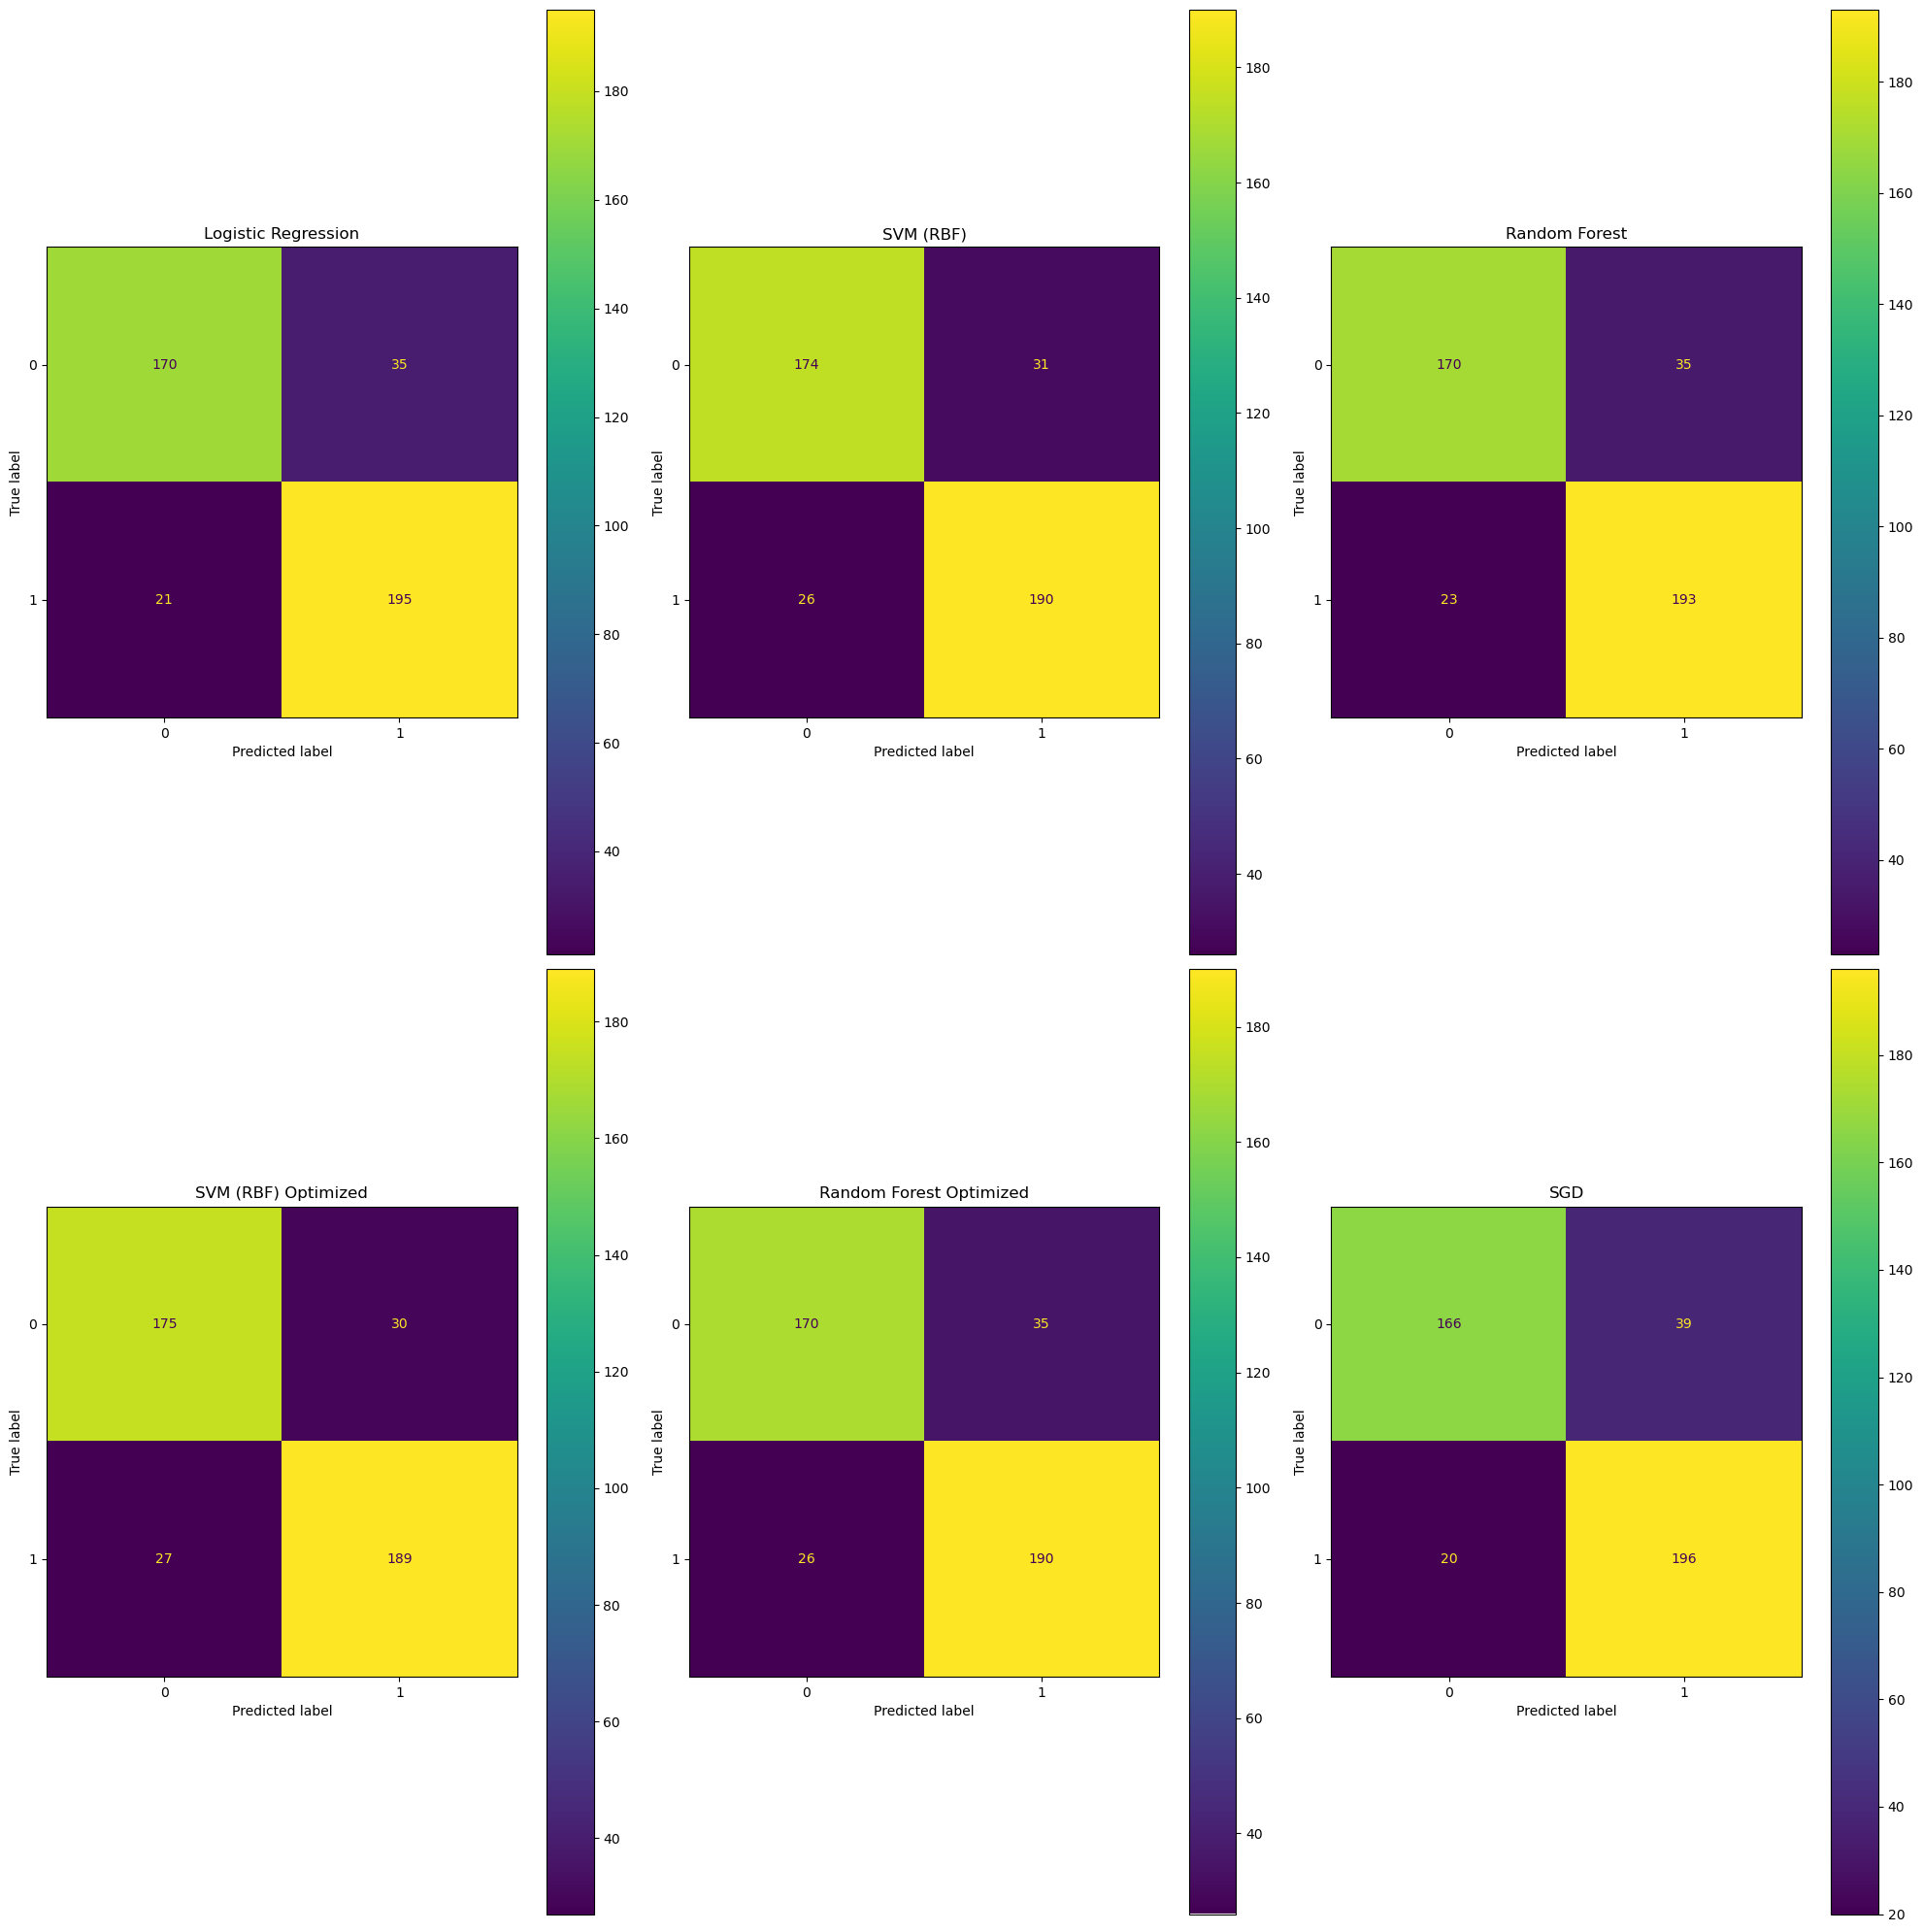

In [108]:
# figure to hold all confusion matrices
plt.figure(figsize=(20, 20))

fig, axes = plt.subplots(2, 3 ,figsize=(20, 20))

# loop through all confusion matrices and plot them
for i, (name, cm) in enumerate(cm_dict.items()):
    ax = axes[i // 3, i % 3]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    ax.set_title(name)

plt.tight_layout()

In [109]:
results_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.866983,0.847826,0.902778,0.874439
SVM (RBF),0.864608,0.859729,0.879630,0.869565
SVM (RBF) Optimized,0.864608,0.863014,0.875000,0.868966
Random Forest,0.862233,0.846491,0.893519,0.869369
Random Forest Optimized,0.855107,0.844444,0.879630,0.861678
SGD,0.859857,0.834043,0.907407,0.869180


The​‍​‌‍​‍‌​‍​‌‍​‍‌ confusion matrices indicate that the models have made very similar predictions. In general, all models show good results, as all of them arey balanced between the two classes. The performance of the optimized versions of SVM and Random Forest is almost identical to that of the original models, which implies that tuning did not change their behavior significantly. The SGD model is also very close to the others in terms of performance, with a few more errors. Viewing the confusion metrics for all of the models give us a stronger proof that the models have succeeded in distinguishing the two income groups.

## 10. ROC Curves

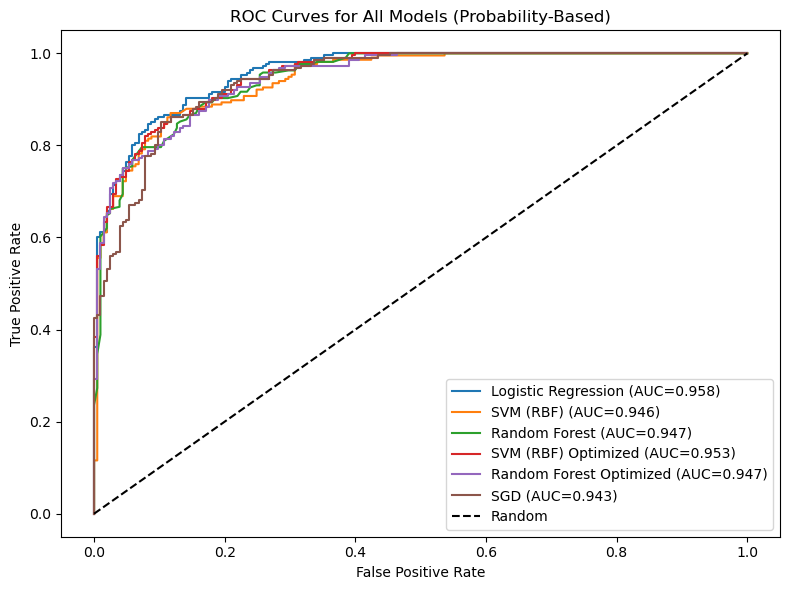

In [110]:
# display ROC curves for all models
plt.figure(figsize=(8, 6))

for name, y_proba in proba_dict.items():
    fpr, tpr, _ = roc_curve(y_test_class, y_proba[:, 1])
    auc = roc_auc_score(y_test_class, y_proba[:, 1])

    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models (Probability-Based)")
plt.legend()
plt.tight_layout()
plt.show()


## 11. Conclusions and Future Work
Every​‍​‌‍​‍‌​‍​‌‍​‍‌ model we trained and valided in this part came with results and were almost identical. Logistic Regression was the model that achieved the maximum overall performance as it had the highest recall, F1 score, and AUC. The SVM and Random Forest models were also strong performers and only differed slightly from Logistic Regression.

We used Grid Search to try an optimize the less-performed models: SVM and Random Forest. Both optimization processes models barely showed any improvment. This indicates that the original parameters were almost perfect for this dataset and problem statemt. The confusion matrices also confirmed that all models have made only a few errors, and none have significant weaknesses in predicting either class.

Finally, we displayed the ROC curves. The results were in line with these conclusions as well, with AUC scores ranging from 0.94 to 0.96 for all models. This indicates that every model was able to distinguish the two income groups at a very high level.

To sum up, out final conclusion is the Logistic Regression is the best model to fit our problem statement and dataset. This is due to the fact that our of all the models that were examined, Logistic Regression is the least complex and the most simple one. Also, it gave the best results. When thinking about scaled programs, complexity has a huge consideration, and we believe that Logistic Regression is the best fit in all aspects.